In [1]:
import torch
import torch.nn as nn
import torchvision
from typing import List
import torch.nn.functional as F
from torchvision.models import vgg16
from collections import namedtuple
import requests
from torch.optim import Adam
from labml_nn.diffusion.stable_diffusion.model.unet_attention import SpatialTransformer
import math
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

/home/reddyanugu/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/reddyanugu/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path


class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)

    def forward(self, real_x, fake_x):
        real_x = 2*real_x - 1
        fake_x = 2*fake_x - 1
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale


class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)

In [46]:
def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample, num_heads, num_layers, attn, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(self.t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            
            self.attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb=None):
        out = x
        for i in range(self.num_layers):
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            if self.attn:
                # Attention block of Unet
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        # Downsample
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads, num_layers, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers + 1)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers + 1)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers + 1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(norm_channels, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers + 1)
            ]
        )
    
    def forward(self, x, t_emb=None):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i + 1](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i + 1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i + 1](out)
            out = out + self.residual_input_conv[i + 1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 up_sample, num_heads, num_layers, attn, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [
                    nn.GroupNorm(norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )
            
            self.attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels, in_channels,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down=None, t_emb=None):
        # Upsample
        x = self.up_sample_conv(x)
        
        # Concat with Downblock output
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            # Renset Block
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Self Attention
            if self.attn:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        return out


class UpBlockUnet(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample,
                 num_heads, num_layers, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
            
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down=None, t_emb=None):
        x = self.up_sample_conv(x)
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            # Resnet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            # Self Attention
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
        
        return out

In [45]:
class VQVAE(nn.Module):
    def __init__(self, im_channels, model_config):
        super().__init__()
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        
        # To disable attention in Downblock of Encoder and Upblock of Decoder
        self.attns = model_config['attn_down']
        
        # Latent Dimension
        self.z_channels = model_config['z_channels']
        self.codebook_size = model_config['codebook_size']
        self.norm_channels = model_config['norm_channels']
        self.num_heads = model_config['num_heads']
        
        # Assertion to validate the channel information
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-1]
        assert len(self.down_sample) == len(self.down_channels) - 1
        assert len(self.attns) == len(self.down_channels) - 1
        
        # Wherever we use downsampling in encoder correspondingly use
        # upsampling in decoder
        self.up_sample = list(reversed(self.down_sample))
        
        ##################### Encoder ######################
        self.encoder_conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        # Downblock + Midblock
        self.encoder_layers = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.encoder_layers.append(DownBlock(self.down_channels[i], self.down_channels[i + 1],
                                                 t_emb_dim=None, down_sample=self.down_sample[i],
                                                 num_heads=self.num_heads,
                                                 num_layers=self.num_down_layers,
                                                 attn=self.attns[i],
                                                 norm_channels=self.norm_channels))
        
        self.encoder_mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.encoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))
        
        self.encoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[-1])
        self.encoder_conv_out = nn.Conv2d(self.down_channels[-1], self.z_channels, kernel_size=3, padding=1)
        
        # Pre Quantization Convolution
        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        
        # Codebook
        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)
        ####################################################
        
        ##################### Decoder ######################
        
        # Post Quantization Convolution
        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        self.decoder_conv_in = nn.Conv2d(self.z_channels, self.mid_channels[-1], kernel_size=3, padding=(1, 1))
        
        # Midblock + Upblock
        self.decoder_mids = nn.ModuleList([])
        for i in reversed(range(1, len(self.mid_channels))):
            self.decoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i - 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))
        
        self.decoder_layers = nn.ModuleList([])
        for i in reversed(range(1, len(self.down_channels))):
            self.decoder_layers.append(UpBlock(self.down_channels[i], self.down_channels[i - 1],
                                               t_emb_dim=None, up_sample=self.down_sample[i - 1],
                                               num_heads=self.num_heads,
                                               num_layers=self.num_up_layers,
                                               attn=self.attns[i-1],
                                               norm_channels=self.norm_channels))
        
        self.decoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[0])
        self.decoder_conv_out = nn.Conv2d(self.down_channels[0], im_channels, kernel_size=3, padding=1)
    
    def quantize(self, x):
        B, C, H, W = x.shape
        
        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1)
        
        # B, H, W, C -> B, H*W, C
        x = x.reshape(x.size(0), -1, x.size(-1))
        
        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        
        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commmitment_loss
        }
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()
        
        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        return quant_out, quantize_losses, min_encoding_indices

    def encode(self, x):
        out = self.encoder_conv_in(x)
        for idx, down in enumerate(self.encoder_layers):
            out = down(out)
        for mid in self.encoder_mids:
            out = mid(out)
        out = self.encoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.encoder_conv_out(out)
        out = self.pre_quant_conv(out)
        out, quant_losses, _ = self.quantize(out)
        return out, quant_losses
    
    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder_conv_in(out)
        for mid in self.decoder_mids:
            out = mid(out)
        for idx, up in enumerate(self.decoder_layers):
            out = up(out)
        
        out = self.decoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.decoder_conv_out(out)
        return out
    
    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses

In [44]:
class Discriminator(nn.Module):
    r"""
    PatchGAN Discriminator.
    Rather than taking IMG_CHANNELSxIMG_HxIMG_W all the way to
    1 scalar value , we instead predict grid of values.
    Where each grid is prediction of how likely
    the discriminator thinks that the image patch corresponding
    to the grid cell is real
    """
    
    def __init__(self, im_channels=3,
                 conv_channels=[64, 128, 256],
                 kernels=[4,4,4,4],
                 strides=[2,2,2,1],
                 paddings=[1,1,1,1]):
        super().__init__()
        self.im_channels = im_channels
        activation = nn.LeakyReLU(0.2)
        layers_dim = [self.im_channels] + conv_channels + [1]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers_dim[i], layers_dim[i + 1],
                          kernel_size=kernels[i],
                          stride=strides[i],
                          padding=paddings[i],
                          bias=False if i !=0 else True),
                nn.BatchNorm2d(layers_dim[i + 1]) if i != len(layers_dim) - 2 and i != 0 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Identity()
            )
            for i in range(len(layers_dim) - 1)
        ])
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist = datasets.MNIST(root="data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(mnist, batch_size=32, shuffle=True)

In [41]:
def train():
    
    model = VQVAE(im_channels, model_config).to(device)
    lpips_model = LPIPS().eval().to(device)
    discriminator = Discriminator(im_channels=im_channels).to(device)

    num_epochs = 3

    recon_criteria = nn.MSELoss()
    disc_criteria = nn.BCEWithLogitsLoss()

    optimizer_d = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_g = Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    disc_step_start = 1500
    step_count = 0

    for epoch_idx in range(num_epochs):
        for im in tqdm(train_loader):
            optimizer_d.zero_grad()
            optimizer_g.zero_grad()

            step_count += 1
            im = im[0].to(device)

            model_output = model(im)
            output, z, quantize_losses = model_output

            recon_loss = recon_criteria(output, im)
            g_loss = (
                recon_loss + quantize_losses['codebook_loss'] + 0.2*quantize_losses['commitment_loss']
            )
            if (step_count > disc_step_start):
                disc_fake_pred = discriminator(output)
                disc_fake_loss = disc_criteria(disc_fake_pred, torch.ones(disc_fake_pred.shape).to(device))
                g_loss += disc_fake_loss
            lpips_loss = torch.mean(lpips_model(output, im))
            g_loss += lpips_loss
            g_loss.backward(retain_graph=True)
            optimizer_g.step()

            if (step_count > disc_step_start):
                fake = output
                disc_fake_pred = discriminator(fake.detach())
                disc_real_pred = discriminator(im)
                disc_fake_loss = disc_criteria(disc_fake_pred, torch.zeros(disc_fake_pred.shape).to(device))
                disc_real_loss = disc_criteria(disc_real_pred, torch.ones(disc_real_pred.shape).to(device))
                disc_loss = (disc_fake_loss + disc_real_loss) / 2
                disc_loss.backward()
                optimizer_d.step()
        
        print(f"Epoch {epoch_idx} => G Loss: {g_loss}, D Loss: {disc_loss if step_count > disc_step_start else None}")
    
    return model, discriminator

In [42]:
im_channels = 1
model_config = {
    'down_channels': [ 32, 32],
    'mid_channels': [32],
    'down_sample': [True],
    'num_down_layers': 2,
    'num_mid_layers': 1,
    'num_up_layers': 1,
    'attn_down': [False],
    'z_channels': 1,
    'codebook_size': 10,
    'norm_channels': 32,
    'num_heads': 1
}
model = VQVAE(im_channels, model_config).to(device)
x = torch.rand(10, 1, 28, 28).to(device)
out = model(x)
print(out[1].shape)

torch.Size([10, 1, 14, 14])


In [48]:
model, discriminator = train()

/home/reddyanugu/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/reddyanugu/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1875/1875 [00:44<00:00, 42.07it/s]


Epoch 0 => G Loss: 0.3281126916408539, D Loss: 0.8073656558990479


100%|██████████| 1875/1875 [00:49<00:00, 37.56it/s]


Epoch 1 => G Loss: 0.3488299250602722, D Loss: 0.7383100986480713


100%|██████████| 1875/1875 [00:49<00:00, 37.60it/s]

Epoch 2 => G Loss: 0.33945414423942566, D Loss: 0.7528702616691589


In [49]:
# save the model
torch.save(model.state_dict(), "pm_prediction_1.pth")
torch.save(discriminator.state_dict(), "pm_prediction_2.pth")

In [50]:
# load the model
model = VQVAE(im_channels, model_config).to(device)
model.load_state_dict(torch.load("pm_prediction_1.pth"))
model.eval()

VQVAE(
  (encoder_conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_layers): ModuleList(
    (0): DownBlock(
      (resnet_conv_first): ModuleList(
        (0-1): 2 x Sequential(
          (0): GroupNorm(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (resnet_conv_second): ModuleList(
        (0-1): 2 x Sequential(
          (0): GroupNorm(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (residual_input_conv): ModuleList(
        (0-1): 2 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (down_sample_conv): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoder_mids): ModuleList()
  (encoder_norm_out): GroupNorm(32, 32, eps=1e-05, affine=True)
  (encoder_conv_out): Conv2d(32, 1, kernel_

In [51]:
model(torch.rand(10, 1, 28, 28).to(device))[1].shape

torch.Size([10, 1, 14, 14])

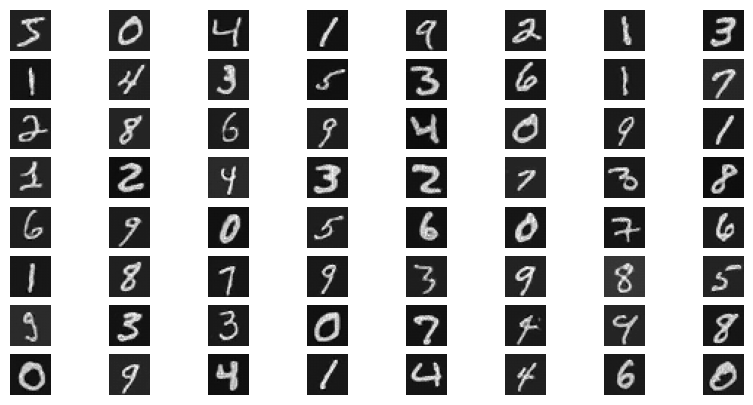

In [52]:
fig, ax = plt.subplots(8, 8, figsize=(10, 5))
for i in range(8):
    for j in range(8):
        x = train_loader.dataset[i*8 + j][0].unsqueeze(0).to(device)
        output, z, quantize_losses = model(x)
        ax[i, j].imshow(output.detach().cpu().numpy().squeeze(), cmap="gray")
        ax[i, j].axis("off")

In [26]:
class UNetModel(nn.Module):
    """
    ## U-Net model
    """

    def __init__(
            self, *,
            in_channels: int,
            out_channels: int,
            channels: int,
            n_res_blocks: int,
            attention_levels: List[int],
            channel_multipliers: List[int],
            n_heads: int,
            tf_layers: int = 1,
            d_cond: int = 768):
        """
        :param in_channels: is the number of channels in the input feature map
        :param out_channels: is the number of channels in the output feature map
        :param channels: is the base channel count for the model
        :param n_res_blocks: number of residual blocks at each level
        :param attention_levels: are the levels at which attention should be performed
        :param channel_multipliers: are the multiplicative factors for number of channels for each level
        :param n_heads: is the number of attention heads in the transformers
        :param tf_layers: is the number of transformer layers in the transformers
        :param d_cond: is the size of the conditional embedding in the transformers
        """
        super().__init__()
        self.channels = channels

        # Number of levels
        levels = len(channel_multipliers)
        # Size time embeddings
        d_time_emb = channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(channels, d_time_emb),
            nn.SiLU(),
            nn.Linear(d_time_emb, d_time_emb),
        )

        # Input half of the U-Net
        self.input_blocks = nn.ModuleList()
        # Initial $3 \times 3$ convolution that maps the input to `channels`.
        # The blocks are wrapped in `TimestepEmbedSequential` module because
        # different modules have different forward function signatures;
        # for example, convolution only accepts the feature map and
        # residual blocks accept the feature map and time embedding.
        # `TimestepEmbedSequential` calls them accordingly.
        self.input_blocks.append(TimestepEmbedSequential(
            nn.Conv2d(in_channels, channels, 3, padding=1)))
        # Number of channels at each block in the input half of U-Net
        input_block_channels = [channels]
        # Number of channels at each level
        channels_list = [channels * m for m in channel_multipliers]
        # Prepare levels
        for i in range(levels):
            # Add the residual blocks and attentions
            for _ in range(n_res_blocks):
                # Residual block maps from previous number of channels to the number of
                # channels in the current level
                layers = [ResBlock(channels, d_time_emb, out_channels=channels_list[i])]
                channels = channels_list[i]
                # Add transformer
                if i in attention_levels:
                    layers.append(SpatialTransformer(channels, n_heads, tf_layers, d_cond))
                # Add them to the input half of the U-Net and keep track of the number of channels of
                # its output
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_channels.append(channels)
            # Down sample at all levels except last
            if i != levels - 1:
                self.input_blocks.append(TimestepEmbedSequential(DownSample(channels)))
                input_block_channels.append(channels)

        # The middle of the U-Net
        self.middle_block = TimestepEmbedSequential(
            ResBlock(channels, d_time_emb),
            SpatialTransformer(channels, n_heads, tf_layers, d_cond),
            ResBlock(channels, d_time_emb),
        )

        # Second half of the U-Net
        self.output_blocks = nn.ModuleList([])
        # Prepare levels in reverse order
        for i in reversed(range(levels)):
            # Add the residual blocks and attentions
            for j in range(n_res_blocks + 1):
                # Residual block maps from previous number of channels plus the
                # skip connections from the input half of U-Net to the number of
                # channels in the current level.
                layers = [ResBlock(channels + input_block_channels.pop(), d_time_emb, out_channels=channels_list[i])]
                channels = channels_list[i]
                # Add transformer
                if i in attention_levels:
                    layers.append(SpatialTransformer(channels, n_heads, tf_layers, d_cond))
                # Up-sample at every level after last residual block
                # except the last one.
                # Note that we are iterating in reverse; i.e. `i == 0` is the last.
                if i != 0 and j == n_res_blocks:
                    layers.append(UpSample(channels))
                # Add to the output half of the U-Net
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        # Final normalization and $3 \times 3$ convolution
        self.out = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1),
        )

    def time_step_embedding(self, time_steps: torch.Tensor, max_period: int = 10000):
        """
        ## Create sinusoidal time step embeddings

        :param time_steps: are the time steps of shape `[batch_size]`
        :param max_period: controls the minimum frequency of the embeddings.
        """
        # $\frac{c}{2}$; half the channels are sin and the other half is cos,
        half = self.channels // 2
        # $\frac{1}{10000^{\frac{2i}{c}}}$
        frequencies = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=time_steps.device)
        # $\frac{t}{10000^{\frac{2i}{c}}}$
        args = time_steps[:, None].float() * frequencies[None]
        # $\cos\Bigg(\frac{t}{10000^{\frac{2i}{c}}}\Bigg)$ and $\sin\Bigg(\frac{t}{10000^{\frac{2i}{c}}}\Bigg)$
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x: torch.Tensor, time_steps: torch.Tensor, cond: torch.Tensor):
        """
        :param x: is the input feature map of shape `[batch_size, channels, width, height]`
        :param time_steps: are the time steps of shape `[batch_size]`
        :param cond: conditioning of shape `[batch_size, n_cond, d_cond]`
        """
        # To store the input half outputs for skip connections
        x_input_block = []

        # Get time step embeddings
        t_emb = self.time_step_embedding(time_steps)
        t_emb = self.time_embed(t_emb)

        # Input half of the U-Net
        for module in self.input_blocks:
            x = module(x, t_emb, cond)
            x_input_block.append(x)
        # Middle of the U-Net
        x = self.middle_block(x, t_emb, cond)
        # Output half of the U-Net
        for module in self.output_blocks:
            x = torch.cat([x, x_input_block.pop()], dim=1)
            x = module(x, t_emb, cond)

        # Final normalization and $3 \times 3$ convolution
        return self.out(x)


class TimestepEmbedSequential(nn.Sequential):
    """
    ### Sequential block for modules with different inputs

    This sequential module can compose of different modules such as `ResBlock`,
    `nn.Conv` and `SpatialTransformer` and calls them with the matching signatures
    """

    def forward(self, x, t_emb, cond=None):
        for layer in self:
            if isinstance(layer, ResBlock):
                x = layer(x, t_emb)
            elif isinstance(layer, SpatialTransformer):
                x = layer(x, cond)
            else:
                x = layer(x)
        return x


class UpSample(nn.Module):
    """
    ### Up-sampling layer
    """

    def __init__(self, channels: int):
        """
        :param channels: is the number of channels
        """
        super().__init__()
        # $3 \times 3$ convolution mapping
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        """
        # Up-sample by a factor of $2$
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        # Apply convolution
        return self.conv(x)


class DownSample(nn.Module):
    """
    ## Down-sampling layer
    """

    def __init__(self, channels: int):
        """
        :param channels: is the number of channels
        """
        super().__init__()
        # $3 \times 3$ convolution with stride length of $2$ to down-sample by a factor of $2$
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        """
        # Apply convolution
        return self.op(x)


class ResBlock(nn.Module):
    """
    ## ResNet Block
    """

    def __init__(self, channels: int, d_t_emb: int, *, out_channels=None):
        """
        :param channels: the number of input channels
        :param d_t_emb: the size of timestep embeddings
        :param out_channels: is the number of out channels. defaults to `channels.
        """
        super().__init__()
        # `out_channels` not specified
        if out_channels is None:
            out_channels = channels

        # First normalization and convolution
        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1),
        )

        # Time step embeddings
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_t_emb, out_channels),
        )
        # Final convolution layer
        self.out_layers = nn.Sequential(
            normalization(out_channels),
            nn.SiLU(),
            nn.Dropout(0.),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        # `channels` to `out_channels` mapping layer for residual connection
        if out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, out_channels, 1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        :param t_emb: is the time step embeddings of shape `[batch_size, d_t_emb]`
        """
        # Initial convolution
        h = self.in_layers(x)
        # Time step embeddings
        t_emb = self.emb_layers(t_emb).type(h.dtype)
        # Add time step embeddings
        h = h + t_emb[:, :, None, None]
        # Final convolution
        h = self.out_layers(h)
        # Add skip connection
        return self.skip_connection(x) + h


class GroupNorm32(nn.GroupNorm):
    """
    ### Group normalization with float32 casting
    """

    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def normalization(channels):
    """
    ### Group normalization

    This is a helper function, with fixed number of groups..
    """
    return GroupNorm32(32, channels)


def _test_time_embeddings():
    """
    Test sinusoidal time step embeddings
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))
    m = UNetModel(in_channels=1, out_channels=1, channels=320, n_res_blocks=1, attention_levels=[],
                  channel_multipliers=[],
                  n_heads=1, tf_layers=1, d_cond=1)
    te = m.time_step_embedding(torch.arange(0, 1000))
    plt.plot(np.arange(1000), te[:, [50, 100, 190, 260]].numpy())
    plt.legend(["dim %d" % p for p in [50, 100, 190, 260]])
    plt.title("Time embeddings")
    plt.show()

In [53]:
class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0).to(device)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod).to(device)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod).to(device)
        
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape)-1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape)-1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the nosie predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = (xt - (self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)) / torch.sqrt(self.alpha_cum_prod[t])
        x0 = torch.clamp(x0, -1., 1.)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean / torch.sqrt(self.alphas[t])
        
        if t == 0:
            return mean, mean
        else:
            variance = (1-self.alpha_cum_prod[t-1]) / (1.0 - self.alpha_cum_prod[t])
            variance = variance * self.betas[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma*z, x0

    def sample_prev_timestep_ddim (self, xt, noise_pred, t, prev_t):

        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t]*noise_pred) / torch.sqrt(self.alpha_cum_prod[t])
        x0 = torch.clamp(x0, -1., 1.)
        xt_prev = self.sqrt_alpha_cum_prod[prev_t] * x0 + self.sqrt_one_minus_alpha_cum_prod[prev_t]*noise_pred
        return xt_prev, x0

In [54]:
in_channels = 1
out_channels = 1
channels = 32
n_res_block = 2
attention_levels = [1,2]
channel_multipliers = [2, 3]
n_heads = 2
tf_layers = 1
d_cond = 768

In [55]:
u_net_model = UNetModel(in_channels=in_channels, out_channels=out_channels, channels=channels, n_res_blocks=n_res_block,
                        attention_levels=attention_levels, channel_multipliers=channel_multipliers, n_heads=n_heads, 
                        tf_layers=tf_layers, d_cond=d_cond).to(device)
ls = LinearNoiseScheduler(1000, 1e-4, 0.02)

In [56]:
u_net_model.train()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): C

In [220]:
for param in model.parameters():
    param.requires_grad = False

In [57]:
num_epochs = 5
optimizer = torch.optim.Adam(u_net_model.parameters(), lr=1e-4)
loss_array = []

In [59]:
for epoch in tqdm(range(num_epochs)):
    for batch in train_loader:
        im = batch[0].to(device)
        with torch.no_grad():
            im, _ = model.encode(im)
        t = torch.randint(0, 1000, (32,)).to(device)
        cond = torch.zeros(32, 1, 768).to(device)
        noise = torch.randn_like(im).to(device)
        xt = ls.add_noise(im, noise, t).to(device)
        noise_pred = u_net_model(xt, t, cond)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_array.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

 20%|██        | 1/5 [01:36<06:26, 96.58s/it]

Epoch [1/5], Loss: 0.12759628891944885


 40%|████      | 2/5 [03:13<04:49, 96.55s/it]

Epoch [2/5], Loss: 0.0977059155702591


 60%|██████    | 3/5 [04:47<03:11, 95.62s/it]

Epoch [3/5], Loss: 0.061664581298828125


 80%|████████  | 4/5 [06:22<01:35, 95.45s/it]

Epoch [4/5], Loss: 0.09020799398422241


100%|██████████| 5/5 [07:58<00:00, 95.65s/it]

Epoch [5/5], Loss: 0.09462998807430267


In [67]:
# save u_net_model
torch.save(u_net_model.state_dict(), "pm_prediction_3.pth")

In [60]:
u_net_model.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): C

In [63]:
def generate_image (ddim=False, end_timestep=999, skip=10):
    # memory_used_values = get_gpu_memory_usage()
    # print("GPU Memory Usage:", memory_used_values[1])
    xt = torch.randn(100, 1, 14, 14).to(device)
    cond = torch.zeros(100, 1, 768).to(device)
    # memory_used_values = get_gpu_memory_usage()
    # print("GPU Memory Usage:", memory_used_values[1])
    if ddim:
        timestamps = torch.arange(end_timestep, 0, -1*skip)[:, None].to(device)
    else:
        timestamps = torch.arange(end_timestep, 0, -1)[:, None].to(device)
    for t in tqdm(timestamps):
        index = torch.where(timestamps == t)[0]
        with torch.no_grad():
            noise_pred = u_net_model(xt, t, cond)
            if ddim:
                if (index + 1) != len(timestamps):
                    xt, x0 = ls.sample_prev_timestep_ddim(xt, noise_pred, t, timestamps[index+1])
            else:
                xt, x0 = ls.sample_prev_timestep(xt, noise_pred, t)
    return xt

In [64]:
images = generate_image()

100%|██████████| 999/999 [00:13<00:00, 74.53it/s]


In [65]:
decoded_images = model.decode(images)

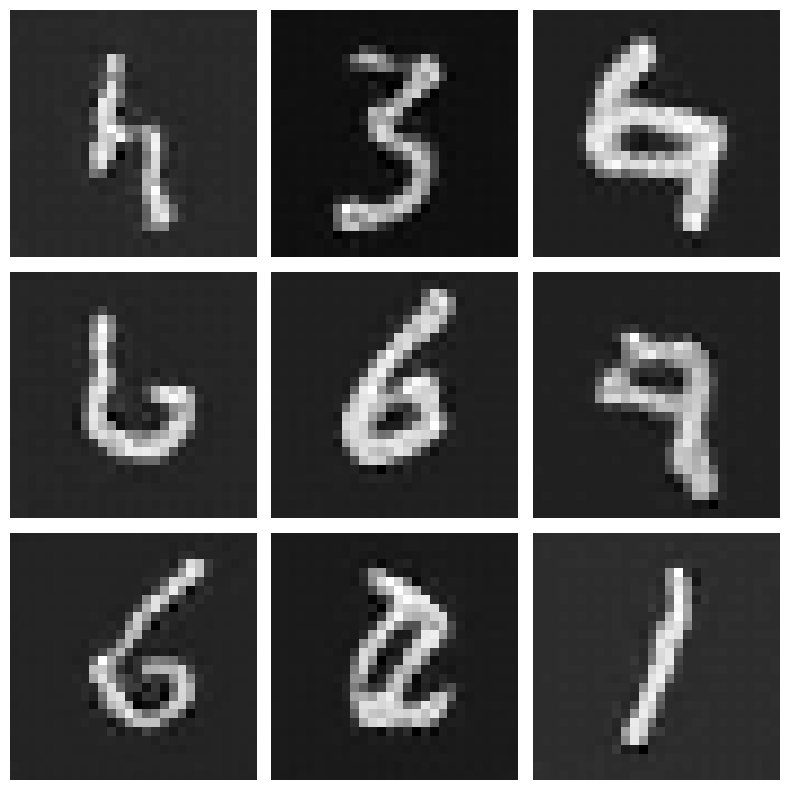

In [66]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

# Iterate through the images and plot them on the subplots
for i, ax in enumerate(axes.flatten()):
    ax.imshow(decoded_images[i][0, :, :].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()